In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import folium
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display

In [18]:
# 데이터 로드 및 전처리
df = pd.read_csv('train_taxi_tims.csv', encoding='euc-kr')
df = df.iloc[45:]  # 결측치 제거
df['승차시간'] = pd.to_datetime(df['승차시간'])
df['월'] = df['승차시간'].dt.month
df['요일'] = df['승차시간'].dt.day_name()
df['시간'] = df['승차시간'].dt.hour

# 요일 매핑
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df['요일_숫자'] = df['요일'].map(day_mapping)


In [19]:
def find_optimal_eps(coords, min_pts):
    neigh = NearestNeighbors(n_neighbors=min_pts)
    nbrs = neigh.fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    plt.plot(distances)
    plt.ylabel("Distance")
    plt.xlabel("Points")
    plt.show()
    return distances


In [20]:
def recommend_location(month, day, hour):
    # 입력된 조건에 맞는 데이터 필터링
    filtered_df = df[(df['월'] == month) & (df['요일_숫자'] == day_mapping[day]) & (df['시간'] == hour)]

    if filtered_df.empty:
        return "해당 조건에 맞는 데이터가 없습니다."

    # DBSCAN 적용
    coords = filtered_df[['승차X좌표', '승차Y좌표']].values
    min_pts = max(2, len(coords) // 20)  # minPts는 최소 2 또는 데이터 개수의 1/10

    # 최적의 epsilon 찾기
    distances = find_optimal_eps(coords, min_pts)
    epsilon = np.percentile(distances, 90)  # 90th percentile as epsilon

    db = DBSCAN(eps=epsilon, min_samples=min_pts).fit(coords)

    # 클러스터 레이블 및 개수 확인
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters == 0:
        return f"클러스터링 결과가 없습니다. 현재 ε 값: {epsilon}"

    # 가장 큰 클러스터 찾기
    largest_cluster = max(set(labels) - {-1}, key=list(labels).count)
    largest_cluster_points = coords[labels == largest_cluster]

    # 클러스터의 중심점 계산
    center = np.mean(largest_cluster_points, axis=0)

    # 지도 생성
    m = folium.Map(location=[center[1], center[0]], zoom_start=14)

    # 모든 포인트를 파란색으로 표시
    for point in coords:
        folium.CircleMarker([point[1], point[0]], radius=5, color='blue', fill=True).add_to(m)

    # 가장 큰 클러스터의 포인트들을 빨간색으로 표시
    for point in largest_cluster_points:
        folium.CircleMarker([point[1], point[0]], radius=5, color='red', fill=True).add_to(m)

    # 클러스터 중심점을 별표로 표시
    folium.Marker([center[1], center[0]], icon=folium.Icon(color='green', icon='star')).add_to(m)

    return m, center, epsilon, n_clusters


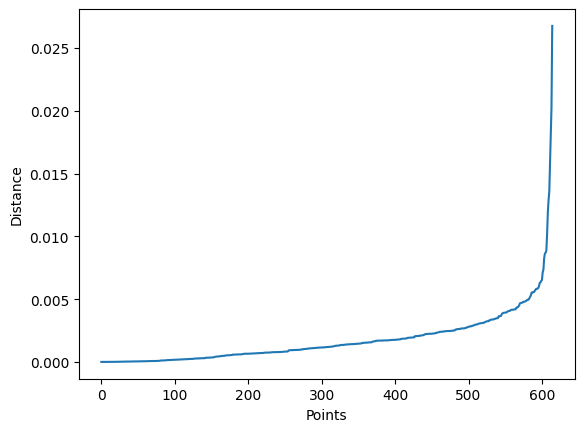

추천 위치: X = 127.37805304444441, Y = 36.3516215086111
사용된 ε 값: 0.003987963052754751
클러스터 수: 2


In [23]:
# 사용 예시
month = 4
day = 'Saturday'
hour = 14

result = recommend_location(month, day, hour)

if isinstance(result, tuple):
    map_obj, center, epsilon, n_clusters = result
    display(map_obj)
    print(f"추천 위치: X = {center[0]}, Y = {center[1]}")
    print(f"사용된 ε 값: {epsilon}")
    print(f"클러스터 수: {n_clusters}")
else:
    print(result)